# Load input data 

In [0]:
# Load libraries 
import numpy as np
#import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os
import csv
import matplotlib.pylab as plt

from scipy.ndimage import rotate
from scipy.ndimage import gaussian_filter
from math import sin,cos,pi
from skimage import exposure

# Mounting google drive
from google.colab import drive
from google.colab import files

# Tensor Flow libraries setup
!pip install tf-nightly
!pip install -U tf-hub-nightly
!pip install tfds-nightly
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from keras import callbacks

print(tf.version.VERSION)

Requirement already up-to-date: tf-hub-nightly in /usr/local/lib/python3.6/dist-packages (0.9.0.dev202004130005)
2.2.0-dev20200413


Using TensorFlow backend.


In [0]:
############################################################################# 
# Mount my google drive where the training/test data is located 
# To run w/o Google Drive mounted, comment out drive.mount() and change work_dir!!
# then, the rest of the code should work just fine in any environment
# There are trhee required folders that should be created before running the
# rest of python codes in this notebook!!!.
# input/
# submissions/
# models/

drive.mount('/content/drive/') # this should be commented out for AWS
# work_dir should be changed for AWS. 
work_dir = '/content/drive/My Drive/Colab Notebooks/Facial Keypoint Detection/'

# Need to mkdir models/ and submissions/ 
models_dir = work_dir + 'models/'
submission_dir = work_dir + 'submissions/'

# Need to have all the files under input/
Train_Dir  = work_dir + 'input/training.csv'
Test_Dir   = work_dir + 'input/test.csv'
lookid_Dir = work_dir + 'input/IdLookupTable.csv'
##############################################################################

# Load Data
with open(Train_Dir, 'r') as csv_file:
  train_data = pd.read_csv(csv_file)  
with open(Test_Dir, 'r') as csv_file:
  test_data = pd.read_csv(csv_file) 
with open(lookid_Dir, 'r') as csv_file:
  lookid_data = pd.read_csv(csv_file)

# Sanity Checks
print(train_data.shape)
print(test_data.shape)
print(lookid_data.shape)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
(7049, 31)
(1783, 2)
(27124, 4)


In [0]:
## Utility functions for prediting and genertaing Kaggle submission files
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


    # Function to plot predictions and generate kaggle submission file
def test_predict(model):
        
    # split out image values from Kaggle test data
    image = []
    for i in range(test_data.shape[0]):
        img = test_data['Image'][i].split(' ')
        img = ['0' if j == '' else j for j in img]
        image.append(img)
    
    # Reshape for prediction
    X_test = np.array(image, dtype = 'float32')
    X_test = np.stack([X_test]*3, axis=-1)
    X_test = X_test.reshape(-1,96,96,3)
    X_test = X_test/255 # pre-trained CNNs expect input is between 0 and 1.0
    
    # predict on test data
    Y_test = model.predict(X_test)
    del image
    return Y_test

def generate_submission(Y_test, model_name, submission_dir, test_data, lookid_data):
    # Generate submission file
    sub1_df = pd.DataFrame(Y_test, columns=train_data.columns[:-1])
    sub2_df = pd.concat([test_data['ImageId'], sub1_df], axis=1)
    sub3_df = pd.melt(sub2_df, id_vars=['ImageId'], value_vars=train_data.columns[:-1]).rename \
            (columns={"variable": "FeatureName", "value": "Location"})
    sub4_df = pd.merge(lookid_data.drop(columns=['Location']), sub3_df, on=['ImageId','FeatureName'], how='left')
    sub_final_df = sub4_df[['RowId', 'Location']]

    print(sub_final_df.shape)
    sub_final_df.head()
    # Save the file
    sub_final_df.to_csv(submission_dir + model_name+'.csv', index=False)
    print(submission_dir + model_name+'.csv has been succefully created for Kaggle submission')

# Split the training data into two sets
- one with more than 7000 examples (d1_label_indices = [0, 1, 2, 3, 20, 21, 28, 29])
- the rest(d2_label_indices = list(range(4, 20)) + list(range(22, 28)))


In [0]:
# First shuffle the Kaggle training data
np.random.seed(533)
shuffle = np.random.permutation(np.arange(train_data.shape[0]))
train_shuff = train_data.iloc[shuffle].reset_index(drop=True)

print("Loading data...")
# Split out image values
images = []
for i in range(train_shuff.shape[0]):
    img = train_shuff['Image'][i].split(' ')
    img = ['0' if j == '' else j for j in img]
    images.append(img) 

X_train_orig = np.array(images, dtype = 'float32')
#X_train_orig = np.stack([X_train_orig]*3, axis=-1)
X_train_orig = X_train_orig.reshape(-1,96,96,1)
X_train_orig = X_train_orig/255 # pre-trained CNNs expect input is between 0 and 1.0
print(X_train_orig.shape)
print(X_train_orig.max())

# Get the keypoint labels
labels = train_shuff.drop('Image', axis = 1)
Y_train_orig = np.array(labels, dtype = 'float32')
print(Y_train_orig.shape)
del images

Loading data...
(7049, 96, 96, 1)
1.0
(7049, 30)


In [0]:
# Dataset 1

# Filter the master dataset based on labels for only 8 keypoints as defined above
d1_label_indices = [0, 1, 2, 3, 20, 21, 28, 29]
Y_train_d1 = Y_train_orig[:, d1_label_indices]

# Remove missing labels
# Get list of non-missing labels
index_list = ~np.isnan(Y_train_d1).any(axis=1)

# Now define the final input images and keypoint labels for Dataset1
X_train_d1 = X_train_orig[index_list]
Y_train_d1 = Y_train_d1[index_list]

print(X_train_d1.shape)
print(Y_train_d1.shape)

# Dataset 2

# Filter the master dataset based on labels for only 22 keypoints as defined above
#keypoints = list(range(4, 20)) + list(range(22, 28))
d2_label_indices = list(range(4, 20)) + list(range(22, 28))
Y_train_d2 = Y_train_orig[:, d2_label_indices]

# Remove missing labels
# Get list of non-missing labels
index_list = ~np.isnan(Y_train_d2).any(axis=1)

# Now define the final input images and keypoint labels for Dataset1
X_train_d2 = X_train_orig[index_list]
Y_train_d2 = Y_train_d2[index_list]

print(X_train_d2.shape)
print(Y_train_d2.shape)

data_augmented = False

(7000, 96, 96, 1)
(7000, 8)
(2155, 96, 96, 1)
(2155, 22)


# Data Augmentation
1. Rotation
2. Histogram Eualization
3. Blurring


In [0]:
# Based on the index of the image in the dataset, the direction of degree of rotation will be done.
# For even numbered indices, the images and keypoints will use +degree rotation.
# For odd numbered indices, the images and keypoints will use -degree rotation.
# This way the augmented dataset will have images rotated in both directions.

# Rotate images at given 'degree' angle
def rotate_images(images, degree):
    
    # create an array for rotated images
    rotated_images = np.zeros((images.shape), dtype=np.float32)
    
    # For each image rotate at angle of given degree 
    # Need to keep the limit between the pixel limits
    for i in range(rotated_images.shape[0]):
        if i%2 == 0:
            angle = degree
        else:
            angle = -degree
            
        rotated_images[i] = np.clip(rotate(images[i], angle, reshape=False, mode='constant', cval=150), 0, 1)  
    return rotated_images
        
    
# Rotate the facial keypoint coordinates at given degree angle
def rotate_keypoints(keypoints, degree, n_points):
    
    # create an array for rotated keypoint coordinates
    rotated_keypoints = np.zeros((keypoints.shape), dtype=np.float32)
    
    # define rotation angle and center of rotation
    #theta = np.radians(degree)
    center_x = 95/2
    center_y = 95/2

    # Loop through each keypoint and do rotation
    for i in range(rotated_keypoints.shape[0]):
        
        if i%2 == 0:
            theta = np.radians(degree)
        else:
            theta = np.radians(-degree)
            
        # obtain x and y coordinates from dataset
        x = keypoints[i][np.arange(0, n_points-1, 2)]
        y = keypoints[i][np.arange(1, n_points, 2)]

        # use rotation matrix to rotate coordinates around center
        new_x = np.cos(theta) * (x - center_x) + np.sin(theta) * (y - center_y) + center_x
        new_y = -np.sin(theta) * (x - center_x) + np.cos(theta) * (y - center_y) + center_y
        
        # put x and y back in original shape
        rotated_keypoints[i] = np.vstack((new_x, new_y)).transpose().flatten()
        
    return rotated_keypoints

In [0]:
## 1.Rotation
degree = 10

# Dataset 1 Augmentation
X_train_rotate = rotate_images(X_train_d1, degree)
y_train_rotate = rotate_keypoints(Y_train_d1, degree, 8)
X_train_d1_ag = np.concatenate((X_train_d1, X_train_rotate), axis=0)
Y_train_d1_ag = np.concatenate((Y_train_d1, y_train_rotate), axis=0)

print(X_train_d1_ag.shape)
print(Y_train_d1_ag.shape)

# Dataset 2 Augmentation
X_train_rotate = rotate_images(X_train_d2, degree)
y_train_rotate = rotate_keypoints(Y_train_d2, degree, 22)
X_train_d2_ag = np.concatenate((X_train_d2, X_train_rotate), axis=0)
Y_train_d2_ag = np.concatenate((Y_train_d2, y_train_rotate), axis=0)

print(X_train_d2_ag.shape)
print(Y_train_d2_ag.shape)

(14000, 96, 96, 1)
(14000, 8)
(4310, 96, 96, 1)
(4310, 22)


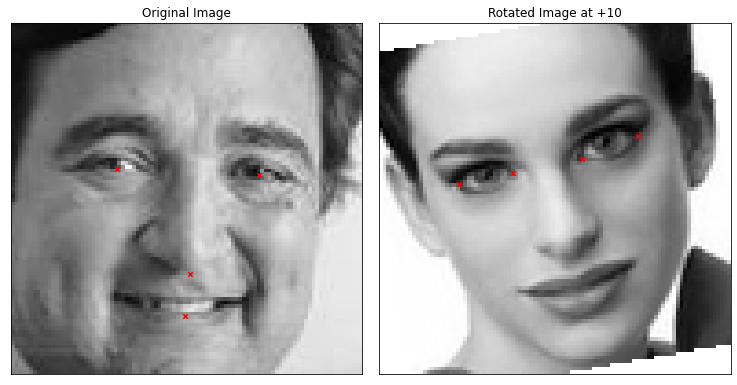

In [0]:
# Plot the results
image_index = 4
# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[image_index].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[image_index, range(0,8,2)], Y_train_d1[image_index, range(1,8,2)], \
           marker = 'x', s=20, color='r')

# Plot the rotated image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
if image_index%2 ==0:
    degree_dir = '+' + str(degree)
else:
    degree_dir = '-' + str(degree)
    
ax.set_title('Rotated Image at '+ degree_dir)
ax.imshow(X_train_rotate[image_index].reshape(96,96),cmap='gray')
ax.scatter(y_train_rotate[image_index, range(0,8,2)], y_train_rotate[image_index,range(1,8,2)], \
           marker = 'x', s=20, color='r')

In [0]:
del X_train_rotate
del y_train_rotate

In [0]:
## 2. Histogram equalizer 
# Make a copy of the training dataset to apply transformation
X_hist_eq = X_train_d1.copy()
X_hist_eq2 = X_train_d2.copy()

# Apply Histogram Equalization to the images
def image_histogram_eq(X_input):
    orig_images = X_input.reshape(96, 96)
    hist_eq_images = exposure.equalize_hist(orig_images)
    
    return hist_eq_images

# Apply histogram equalization on original train data
for index in range(0, len(X_train_d1)):
    X_hist_eq[index] = image_histogram_eq(X_train_d1[index]).reshape(96,96, 1)

for index in range(0, len(X_train_d2)):
    X_hist_eq2[index] = image_histogram_eq(X_train_d2[index]).reshape(96,96, 1)

X_train_d1_ag = np.concatenate((X_train_d1_ag, X_hist_eq), axis=0)
Y_train_d1_ag = np.concatenate((Y_train_d1_ag, Y_train_d1), axis=0)

X_train_d2_ag = np.concatenate((X_train_d2_ag, X_hist_eq2), axis=0)
Y_train_d2_ag = np.concatenate((Y_train_d2_ag, Y_train_d2), axis=0)

print(X_train_d1_ag.shape)
print(Y_train_d1_ag.shape)

print(X_train_d2_ag.shape)
print(Y_train_d2_ag.shape)



(21000, 96, 96, 1)
(21000, 8)
(6465, 96, 96, 1)
(6465, 22)


In [0]:
del X_hist_eq
del X_hist_eq2

In [0]:
## 3. Blurring
# Make a copy of the training dataset to apply transformation
X_blur = X_train_d1.copy()
X_blur2 = X_train_d2.copy()
    
# Apply Gaussian Blur to all the training data images
for index in range(0, len(X_train_d1)):
    X_blur[index] = gaussian_filter(X_blur[index], sigma = 1).reshape(96, 96, 1)
for index in range(0, len(X_train_d2)):
    X_blur2[index] = gaussian_filter(X_blur2[index], sigma = 1).reshape(96, 96, 1)

X_train_d1_ag = np.concatenate((X_train_d1_ag, X_blur), axis=0)
Y_train_d1_ag = np.concatenate((Y_train_d1_ag, Y_train_d1), axis=0)

X_train_d2_ag = np.concatenate((X_train_d2_ag, X_blur2), axis=0)
Y_train_d2_ag = np.concatenate((Y_train_d2_ag, Y_train_d2), axis=0)

print(X_train_d1_ag.shape)
print(Y_train_d1_ag.shape)

print(X_train_d2_ag.shape)
print(Y_train_d2_ag.shape)



(28000, 96, 96, 1)
(28000, 8)
(8620, 96, 96, 1)
(8620, 22)


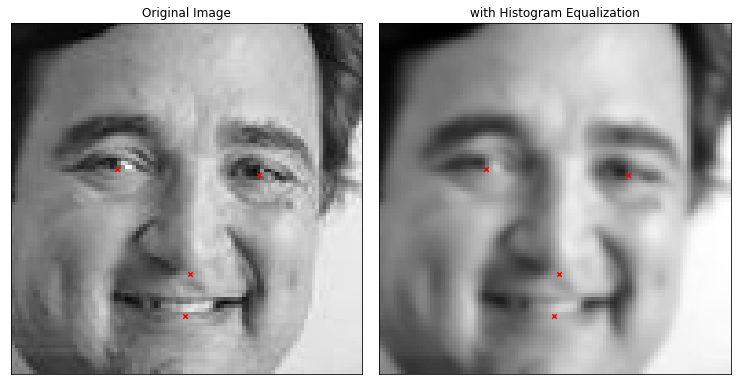

In [0]:
image_index = 4

# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[image_index].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[image_index, range(0, 8, 2)], Y_train_d1[image_index, range(1, 8, 2)], \
           marker = 'x', s=20, color='r')

# Plot the transformed image with train labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Histogram Equalization')
#ax.imshow(X_hist_eq[image_index].reshape(96,96),cmap='gray')
ax.imshow(X_blur[image_index].reshape(96,96),cmap='gray')

ax.scatter(Y_train_d1[image_index, range(0, 8, 2)], Y_train_d1[image_index, range(1, 8, 2)], \
           marker = 'x', s=20, color='r')
    
plt.show()

In [0]:
del X_blur
del X_blur2

In [0]:
## Expand 1-channel images to 3-channels
X_train_d1 = np.stack([X_train_d1_ag]*3, axis=-1)
X_train_d1 = X_train_d1.reshape(-1,96,96,3)
Y_train_d1 = Y_train_d1_ag
print(X_train_d1.shape)
print(Y_train_d1.shape)

X_train_d2 = np.stack([X_train_d2_ag]*3, axis=-1)
X_train_d2 = X_train_d2.reshape(-1,96,96,3)
Y_train_d2 = Y_train_d2_ag
print(X_train_d2.shape)
print(Y_train_d2.shape)

del X_train_d1_ag
del X_train_d2_ag
del Y_train_d1_ag
del Y_train_d2_ag

## 
data_augmented = True

(28000, 96, 96, 3)
(28000, 8)
(8620, 96, 96, 3)
(8620, 22)


# Model Trainig
Need the following data prepared
- X_train_d1, X_train_d2
- Y_train_d1, Y_train_d2
- d1_label_indices, d2_lable_indices


In [0]:
if(data_augmented == False):
  ## Expand 1-channel images to 3-channels
  X_train_d1 = np.stack([X_train_d1]*3, axis=-1)
  X_train_d1 = X_train_d1.reshape(-1,96,96,3)
  print(X_train_d1.shape)
  print(Y_train_d1.shape)

  X_train_d2 = np.stack([X_train_d2]*3, axis=-1)
  X_train_d2 = X_train_d2.reshape(-1,96,96,3)
  print(X_train_d2.shape)
  print(Y_train_d2.shape)

(7000, 96, 96, 3)
(7000, 8)
(2155, 96, 96, 3)
(2155, 22)


In [0]:
# Utility functions required to train models
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [0]:
#Explore complexity of models in consideration
model_urls = {
    "mobilenet_v2_050_96":"https://tfhub.dev/google/imagenet/mobilenet_v2_050_96/feature_vector/4",
    "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",
    "inception_v2":"https://tfhub.dev/google/imagenet/inception_v2/feature_vector/4"
              }
for ml_name in model_urls:
  print("Start training the model:", ml_name, model_urls[ml_name])
  model = tf.keras.Sequential([
      hub.KerasLayer(model_urls[ml_name],
                    trainable=False),  
      tf.keras.layers.Dense(30)
  ])
  model.build([16, 96, 96, 3])  
  model.compile(
    optimizer=tf.
    keras.optimizers.Adam(),
    loss='mean_squared_error',
    metrics=[rmse])
  model.summary()

Start training the model: mobilenet_v2_050_96 https://tfhub.dev/google/imagenet/mobilenet_v2_050_96/feature_vector/4


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_8 (KerasLayer)   (16, 1280)                706224    
_________________________________________________________________
dense_8 (Dense)              (16, 30)                  38430     
Total params: 744,654
Trainable params: 38,430
Non-trainable params: 706,224
_________________________________________________________________
Start training the model: resnet_v2_50 https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_9 (KerasLayer)   (16, 2048)                23564800  
_________________________________________________________________
dense_9 (Dense)              (16, 30)                  61470     
Total params: 23,626,270
Trainable params: 61,470
Non-trainable params: 23,564,800
_________________________________________________________________
Start training the model: inception_v2 https://tfhub.dev/google/imagenet/inception_v2/feature_vector/4


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_10 (KerasLayer)  (16, 1024)                10173112  
_________________________________________________________________
dense_10 (Dense)             (16, 30)                  30750     
Total params: 10,203,862
Trainable params: 30,750
Non-trainable params: 10,173,112
_________________________________________________________________


In [0]:
model_urls = {
    "mobilenet_v2_050_96":"https://tfhub.dev/google/imagenet/mobilenet_v2_050_96/feature_vector/4",
    #"resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",
    "inception_v2":"https://tfhub.dev/google/imagenet/inception_v2/feature_vector/4"
              }
batch_size = [8,16]
epochs = 50
trainable = False

for ml_name in model_urls:
  for bs in batch_size:
    print("Start training the model:", ml_name, model_urls[ml_name], "with batch_size:",bs)
    model_d1 = tf.keras.Sequential([
        hub.KerasLayer(model_urls[ml_name],
                      trainable=trainable ,arguments=dict(batch_norm_momentum=0.997)),  
        tf.keras.layers.Dense(8)
    ])
    model_d1.build([bs, 96, 96, 3])  

    model_d2 = tf.keras.Sequential([
        hub.KerasLayer(model_urls[ml_name],
                       trainable=trainable, arguments=dict(batch_norm_momentum=0.997)),  
        tf.keras.layers.Dense(22)
    ])
    model_d2.build([bs, 96, 96, 3])  

    model_d1.compile(
      optimizer=tf.
      keras.optimizers.Adam(),
      loss='mean_squared_error',
      metrics=[rmse])
    
    model_d2.compile(
      optimizer=tf.
      keras.optimizers.Adam(),
      loss='mean_squared_error',
      metrics=[rmse])

    model_d1.summary()
    model_d2.summary()

    # Train two models
    train_ml_name = ml_name + "_batch_size" + str(bs) + "_epochs" + str(epochs) + "_trainable" + str(trainable)
    history__d1 = model_d1.fit(X_train_d1, Y_train_d1, epochs=epochs, shuffle=True, batch_size=bs, validation_split = 0.2)
    model_d1.save(models_dir + train_ml_name + "_sp1.h5")

    history__d2 = model_d2.fit(X_train_d2, Y_train_d2, epochs=epochs, shuffle=True, batch_size=bs, validation_split = 0.2)
    model_d2.save(models_dir + train_ml_name +"_sp2.h5")

    # Predict 
    Y_test_d1 = test_predict(model_d1)
    Y_test_d2 = test_predict(model_d2)

    # Clipping the predicted results to the valid range [0,96]
    Y_test_d1 [Y_test_d1 > 96] = 96.0
    Y_test_d1 [Y_test_d1 < 0 ] = 0.0
    Y_test_d2 [Y_test_d2 > 96] = 96.0
    Y_test_d2 [Y_test_d2 < 0 ] = 0.0

    # Combine both results
    Y_test_combined = np.zeros((1783, 30), dtype = np.float32)
    Y_test_combined[:, d1_label_indices] = Y_test_d1
    Y_test_combined[:, d2_label_indices] = Y_test_d2

    # Call function to generate kaggle submission file for scoring
    generate_submission(Y_test_combined, train_ml_name, submission_dir, test_data, lookid_data)


Start training the model: inception_v2 https://tfhub.dev/google/imagenet/inception_v2/feature_vector/4 with batch_size: 8
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (8, 1024)                 10173112  
_________________________________________________________________
dense (Dense)                (8, 8)                    8200      
Total params: 10,181,312
Trainable params: 8,200
Non-trainable params: 10,173,112
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (8, 1024)                 10173112  
_________________________________________________________________
dense_1 (Dense)              (8, 22)                   22550     
Total params: 10,195,662
Tra

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (16, 1024)                10173112  
_________________________________________________________________
dense_2 (Dense)              (16, 8)                   8200      
Total params: 10,181,312
Trainable params: 8,200
Non-trainable params: 10,173,112
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (16, 1024)                10173112  
_________________________________________________________________
dense_3 (Dense)              (16, 22)                  22550     
Total params: 10,195,662
Trainable params: 22,550
Non-trainable params: 10,173,112
_________________________________________________________________

KeyboardInterrupt: ignored